In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
from datetime import timedelta
import datetime
import math
import missingno as msno

In [407]:
cd /Users/williamzhou/Downloads/RussianHousing-master

/Users/williamzhou/Downloads/RussianHousing-master


In [408]:
train=pd.read_csv('./data/processed/Clean0517/train_clean_shu_0517.csv')
test = pd.read_csv('./data/processed/Clean0517/test_clean_shu_0517.csv')
macro = pd.read_csv('./data/raw/macro.csv')
# latlon = pd.read_csv('/Users/williamzhou/Documents/github/RussianHousing/data/external/sub_area_lon_lat.csv')
final_feature = list(pd.read_csv('./cv_output/final_feature.csv').iloc[:,0])


train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

print ('train shape',train.shape)
print ('test shape',test.shape)
print('final features',len(final_feature))

('train shape', (30471, 299))
('test shape', (7662, 296))
('final features', 40)


In [409]:
train.loc[train['full_sq'].isnull(),'full_sq']=train['full_sq'].median()
test.loc[test['full_sq'].isnull(),'full_sq']=test['full_sq'].median()
train['price_full_sq']=train['price_doc']/train['full_sq']
train['price_full_sq']=train['price_full_sq'].astype('int64')

print ('train shape',train.shape)
print ('test shape',test.shape)

('train shape', (30471, 300))
('test shape', (7662, 296))


In [410]:
y_train=train['price_full_sq']
x_train= train.drop(['id','price_doc','price_full_sq'],axis=1)
x_test = test.drop(['id'],axis=1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(30471, 297)
(30471,)
(7662, 295)


In [411]:
num_train = len(train)
df_all = pd.concat([x_train,x_test])

df_all[['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_terminal']]=df_all[['ID_big_road1','ID_big_road2',
                                        'ID_bus_terminal','ID_metro',
                                       'ID_railroad_station_avto',
                                       'ID_railroad_terminal']].astype(object)

df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

### Create new features and clean data

In [412]:
df_all_index= df_all.index
df_all = df_all.reset_index(drop=True)

In [401]:
# df_all['life_full_sq_percent'] = df_all['life_sq'] / df_all['full_sq']
# median_percent = np.median(df_all.loc[df_all['life_full_sq_percent']<=1,'life_full_sq_percent'])
# n = 0
# for i in range(len(df_all)):
#     if df_all.loc[i,'full_sq']< df_all.loc[i,'life_sq']:
#         df_all.loc[i,'full_sq'] = df_all.loc[i,'life_sq']/median_percent
#         n+=1
# print('change %d rows'%n)


change 27 rows


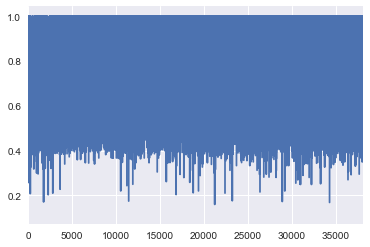

In [387]:
# df_all['life_full_sq_percent'] = df_all['life_sq'] / df_all['full_sq']
# df_all['life_full_sq_percent'].plot()
# plt.show()

In [88]:
# df_all['kitch_full_sq_percent'] = df_all['kitch_sq'] / df_all['full_sq']

# n = 0
# for i in range(len(df_all)):
#     if df_all.loc[i,'kitch_full_sq_percent']>1:
#         df_all.loc[i,'kitch_sq'] = df_all.loc[i,'kitch_sq']/10
#         n+=1
# print('change %d rows'%n)

# df_all['kitch_full_sq_percent'] = df_all['kitch_sq'] / df_all['full_sq']

change 10 rows


In [166]:
# # impute all missing floor with floor median = 6 floor max_floor median = 13 
# # Floor and max floor still have lots of unreasonable data around 2000 rows, needs to deal with later
# median_floor = np.median(df_all.loc[df_all.floor_max_floor<1,'floor'])
# median_max_floor = np.median(df_all.loc[df_all.floor_max_floor<1,'max_floor'])

# df_all['floor_max_floor'] = df_all['floor']/df_all['max_floor']
# for i in range(len(df_all)):
#     if np.isnan(df_all.loc[i,'floor']) or np.isnan(df_all.loc[i,'max_floor']):
#         df_all.loc[i,'floor'] =  median_floor
#         df_all.loc[i,'max_floor'] = median_max_floor

# df_all['floor_max_floor'] = df_all['floor']/df_all['max_floor']

In [174]:
# # Life sq missing imputation 
# median_life_full_ratio = np.median(df_all.loc[df_all.life_full_sq_percent<=1,'life_full_sq_percent'])
# n=0
# for i in range(len(df_all)):
#     if np.isnan(df_all.loc[i,'life_sq']):
#         df_all.loc[i,'life_sq'] = df_all.loc[i,'full_sq']*median_life_full_ratio
#         n+=1
# print('{} missing values are imputed'.format(n))

0 missing values are imputed


In [388]:
# # build year missing impute using neighorhood building year weighted average
# n=0
# for i in range(len(df_all)):
#     try:
#         if np.isnan(df_all.loc[i,'build_year']):
#             a= df_all.loc[i,'build_count_before_1920']
#             b= df_all.loc[i,'build_count_1921-1945']
#             c= df_all.loc[i,'build_count_1946-1970']
#             d= df_all.loc[i,'build_count_1971-1995']
#             e= df_all.loc[i,'build_count_after_1995']
#             sum_count = a+b+c+d+e
#             df_all.loc[i,'build_year'] = int((1908*a+1933*b+1958*c+1983*d+2007*e)/sum_count)
#             n+=1
#     except:
#         pass
# print('{} missing values are imputed'.format(n))

11479 missing values are imputed


In [210]:
# # For those row have missing neighorhood building year, 
# # we could calculate the median building year using metro_ID column
# median_build_yr_metroID=df_all.loc[np.isnan(df_all.build_year)==False,['ID_metro','build_year']].groupby('ID_metro')[['build_year']].median()
# median_build_yr_metroID.reset_index(inplace=True)

# n=0
# for i in range(len(df_all)):
#     if np.isnan(df_all.loc[i,'build_year']):
#         metro = int(df_all.loc[i,'ID_metro'])
#         df_all.loc[i,'build_year'] = median_build_yr_metroID.loc[metro,'build_year']
#         n+=1
# print('{} missing values are imputed'.format(n))

In [284]:
# #Kitch_sq missing imputation
# df_all['kitch_life_ratio'] = df_all['kitch_sq']/df_all['life_sq']
# median_kitch_life_ration=np.median(df_all.loc[df_all.kitch_life_ratio.isnull()==False,'kitch_life_ratio'])
# df_all.loc[df_all.kitch_sq.isnull(),'kitch_sq'] = df_all['life_sq']*median_kitch_life_ration

In [307]:
# # Material imputation: mode material of each Metro ID
# mode_material_metroID=df_all.loc[np.isnan(df_all.material)==False,['ID_metro','material']].groupby('ID_metro')[['material']].\
# apply(pd.DataFrame.mode)
# mode_material_metroID.reset_index(inplace=True)
# n=0
# for i in range(len(df_all)):
#     if np.isnan(df_all.loc[i,'material']):
#         metro = int(df_all.loc[i,'ID_metro'])
#         df_all.loc[i,'material'] = mode_material_metroID.loc[metro,'material']
#         n+=1
# print('{} missing values are imputed'.format(n))

9574 missing values are imputed


In [389]:
# # hospital_beds_raion imputation: median material of each Metro ID
# median_hosp_beds_metroID=df_all.loc[np.isnan(df_all.hospital_beds_raion)==False,['ID_metro','hospital_beds_raion']].groupby('ID_metro')[['hospital_beds_raion']].median()
# median_hosp_beds_metroID.reset_index(inplace=True)

# n=0
# for i in range(len(df_all)):

#     if np.isnan(df_all.loc[i,'hospital_beds_raion']):
#         metro = int(df_all.loc[i,'ID_metro'])
#         df_all.loc[i,'hospital_beds_raion'] = median_hosp_beds_metroID.loc[metro,'hospital_beds_raion']
#         n+=1

# print('{} missing values are imputed'.format(n))

KeyError: 'the label [197] is not in the [index]'

In [319]:
# universe_median_hosp_bed=np.median(df_all.loc[df_all.hospital_beds_raion.isnull()==False,'hospital_beds_raion'])
# df_all.loc[df_all.hospital_beds_raion.isnull(),'hospital_beds_raion']=universe_median_hosp_bed

In [402]:
# # Railroad Station walk KM is highly correlated with Railroad Station Avto KM
# df_all['railroad_avto_walk_ratio'] = df_all['railroad_station_walk_km'].astype(float)/df_all['railroad_station_avto_km']
# median_railroad_a_w_ratio_metroID=df_all.loc[np.isnan(df_all.railroad_station_walk_km)==False,['ID_metro','railroad_avto_walk_ratio']].groupby('ID_metro')[['railroad_avto_walk_ratio']].median()
# median_railroad_a_w_ratio_metroID.reset_index(inplace=True)

# n=0
# for i in range(len(df_all)):

#     if np.isnan(df_all.loc[i,'railroad_station_walk_km']):
#         metro = int(df_all.loc[i,'ID_metro'])
#         df_all.loc[i,'railroad_station_walk_km'] = median_railroad_a_w_ratio_metroID.loc[metro,'railroad_avto_walk_ratio']*df_all.loc[i,'railroad_station_avto_km']
#         n+=1

# print('{} missing values are imputed'.format(n))

59 missing values are imputed


In [390]:
# median_presch_metroID=df_all.loc[np.isnan(df_all.preschool_quota)==False,['ID_metro','preschool_quota']].groupby('ID_metro')[['preschool_quota']].median()
# median_presch_metroID.reset_index(inplace=True)

# n=0
# for i in range(len(df_all)):

#     if np.isnan(df_all.loc[i,'preschool_quota']):
#         metro = int(df_all.loc[i,'ID_metro'])
#         df_all.loc[i,'preschool_quota'] = median_presch_metroID.loc[metro,'preschool_quota']
#         n+=1

# print('{} missing values are imputed'.format(n))

8284 missing values are imputed


In [334]:
# # State missing impute using mode by Metro ID 
# mode_state_metroID=df_all.loc[np.isnan(df_all.state)==False,['ID_metro','state']].groupby('ID_metro')[['state']].\
# apply(pd.DataFrame.mode)
# mode_state_metroID.reset_index(inplace=True)
# n=0
# for i in range(len(df_all)):
#     if np.isnan(df_all.loc[i,'state']):
#         metro = int(df_all.loc[i,'ID_metro'])
#         df_all.loc[i,'state'] = mode_state_metroID.loc[metro,'state']
#         n+=1
# print('{} missing values are imputed'.format(n))

14253 missing values are imputed


In [335]:
def missing_percentage(df):
    missing_list={}
    for col_name in df.columns:
        missing_perct=round((sum(df[col_name].isnull())/float(len(df[col_name]))),5)
        missing_list[col_name]=missing_perct
    return(missing_list)
missing_percentage(df_all.loc[:,final_feature])

{'big_church_km': 0.0,
 'build_year': 0.0,
 'cemetery_km': 0.0,
 'church_synagogue_km': 0.0,
 'fitness_km': 0.0,
 'floor': 0.0,
 'full_sq': 0.0,
 'green_part_1500': 0.0,
 'green_part_500': 0.0,
 'green_zone_km': 0.0,
 'hospice_morgue_km': 0.0,
 'hospital_beds_raion': 0.0,
 'ice_rink_km': 0.0,
 'industrial_km': 0.0,
 'kindergarten_km': 0.0,
 'kitch_sq': 0.0,
 'life_sq': 0.0,
 'market_shop_km': 0.0,
 'material': 0.0,
 'max_floor': 0.0,
 'metro_min_avto': 0.0,
 'month_year_cnt': 0.0,
 'mosque_km': 0.0,
 'nuclear_reactor_km': 0.0,
 'num_room': 0.25151,
 'office_sqm_500': 0.0,
 'park_km': 0.0,
 'preschool_quota': 0.0,
 'radiation_km': 0.0,
 'railroad_km': 0.0,
 'railroad_station_walk_km': 0.0,
 'sadovoe_km': 0.0,
 'school_km': 0.0,
 'state': 0.0,
 'swim_pool_km': 0.0,
 'theater_km': 0.0,
 'thermal_power_plant_km': 0.0,
 'water_km': 0.0,
 'water_treatment_km': 0.0,
 'week_year_cnt': 0.0}

In [413]:

x_train = df_all.iloc[:num_train,:]
x_test = df_all.iloc[num_train:,:].reset_index(drop=True)
print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)


('x_train shape', (30471, 299))
('x_test shape', (7662, 299))
('y_train shape', (30471,))


In [414]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

In [415]:
x_train_subset = x_train.loc[:,final_feature]
x_test_subset = x_test.loc[:,final_feature]
dtrain_subset = xgb.DMatrix(x_train_subset, y_train)
dtest_subset =  xgb.DMatrix(x_test_subset)
cv_output = xgb.cv(xgb_params, dtrain_subset, 
                   num_boost_round=1000, 
                   early_stopping_rounds=20,
                   verbose_eval=50, show_stdv=False)

num_boost_rounds = len(cv_output)
print(num_boost_rounds)
print(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain_subset, num_boost_round= num_boost_rounds)
print('Finish XGBoost training')

[0]	train-rmse:137644	test-rmse:137656
[50]	train-rmse:42357.7	test-rmse:44128.3
[100]	train-rmse:38930.5	test-rmse:41692.2
[150]	train-rmse:37374.2	test-rmse:41133.8
[200]	train-rmse:36159.7	test-rmse:40803.7
[250]	train-rmse:35089.7	test-rmse:40634.4
[300]	train-rmse:34193.7	test-rmse:40534.9
[350]	train-rmse:33339	test-rmse:40468.8
[400]	train-rmse:32548.1	test-rmse:40432.6
[450]	train-rmse:31777.1	test-rmse:40406.5
457
     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0     137656.375000     518.822874    137644.328125      251.331099
1     131583.458333     532.695565    131547.802083      244.129053
2     125837.625000     562.104868    125783.411458      237.543497
3     120397.791667     583.676207    120323.851563      234.887814
4     115260.992187     612.720321    115177.606771      229.834781
5     110431.585937     618.932120    110323.528646      240.601518
6     105876.822916     627.069519    105749.372396      248.774887
7     101590.872396     630.0

In [422]:
y_predict = model.predict(dtest_subset)
y_predic_all_sq = (y_predict)*x_test['full_sq']
df_sub = pd.DataFrame({'id': test.id, 'price_doc': y_predic_all_sq*0.975})
df_sub.to_csv('./sub.csv', index=False)
df_sub.head()

,id,price_doc
0,30474,5.437809e+06
1,30475,7.776436e+06
2,30476,5.312257e+06
3,30477,5.674297e+06
4,30478,5.045797e+06
